<a href="https://colab.research.google.com/github/SimonAndren/CS146/blob/LBA/LBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LBA CS146

Name: Simon Andren

# Section 1 - Data processing

In this first section, the submitted data will be cleaned and processed to a structure that fit the analysis.

The aim is to have a dataset where each line represents an array with product price, and the relevant product information. 

Prior to loading the data, I processed it by

*   Converting text to numerical values. This was mostly needed for the rent
*   Changing any commas (",") to dots (".") to make sure the CSV file is correctly imported.
*   Change so that countries and currencies are refered to in the same way (I.e. US vs USA and US dollar vs USD)

## Import data, change column names, covert price, and normalize price

In the follow code cells, the data is imported from a raw github file

The relevent columns are filtered out, the column names are changed
The price is converted to USD and normalized to quantity of 1 kg (or L or 1 piece) 

In [1]:
#Importing the needed libraries
import pandas as pd #Easy table management 
import numpy as np 
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
#Import the data from uploaded github file
url = 'https://raw.githubusercontent.com/SimonAndren/CS146/main/LBA/_CS146%20LBA%20data%20gathering%20-%20Raw%20Data%20(2).csv'
raw_data = pd.read_csv(url)

#view the head
raw_data.head()

,Timestamp,Email Address,Your name,Country where you (and the grocery store) are,Currency (e.g. EUR. GBP. USD),Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,3/4/2021 4:03:50,isabel@minerva.kgi.edu,Isabel Brunkan,Canada,Canadian Dollar,Thrifty's (https://www.thriftyfoods.com),Budget (cheap),1450,1.360,4.75,1.360,4.99,1.360,4.75,0.190,0.33,0.180,0.47,0.080,0.35,0.230,1.77,0.454,5.99,0.180,2.77,0.100,0.44,0.100,0.44,1.000,3.08,2.500,7.49,2.500,3.99,10.000,13.99,1.600,12.99,0.24,4.49,0.907,5.29,2.00,6.49,4.000,6.49,1.50,5.29,0.454,4.49,0.454,6.49,0.454,7.49,18.0,9.05,18.0,8.19,12.0,5.75,0.400,9.25,0.600,16.25,0.780,16.32
1,2/28/2021 20:28:38,isabel@minerva.kgi.edu,Isabel Brunkan,Canada,Canadian Dollar,Save On Foods - Foul Bay (https://www.saveonfo...,Budget (cheap),1550,0.100,0.66,0.100,0.44,0.100,0.88,0.100,0.17,0.100,0.20,0.100,0.66,0.100,0.66,0.100,0.77,0.100,0.66,0.100,0.31,0.100,0.44,0.100,0.18,10.000,12.99,2.000,9.99,1.000,4.99,0.100,0.29,4.54,19.99,2.000,9.99,1.00,4.19,1.000,2.60,4.00,5.29,0.454,4.39,0.454,5.69,0.454,7.69,12.0,5.45,12.0,7.49,12.0,7.69,3.000,23.08,0.100,1.21,0.500,12.11
2,3/2/2021 2:34:17,claudiagold@minerva.kgi.edu,Claudia Jin,US,USD,Target; 225 Bush St Ste 100. San Francisco. CA...,Mid-range,2996,1.361,4.69,1.361,3.59,1.361,2.99,0.910,1.79,0.120,0.25,NaN,NaN,0.454,3.19,0.454,1.29,0.300,2.99,2.268,2.59,0.680,4.99,0.680,3.99,2.268,3.69,0.910,1.89,0.910,10.99,0.240,1.39,0.85,5.99,0.910,3.29,1.89,2.19,1.890,1.99,1.67,3.99,0.430,2.29,0.450,3.69,0.370,5.29,12.0,1.69,18.0,2.39,12.0,3.99,0.454,5.99,1.134,8.59,1.814,8.49
3,3/2/2021 2:32:10,claudiagold@minerva.kgi.edu,Claudia Jin,US,USD,Wholefoods; 399 4th St San Francisco. CA 94107,Luxury (expensive),3360,0.454,2.49,0.454,2.99,0.454,3.99,0.454,0.49,0.454,1.49,0.454,1.99,0.454,1.99,0.454,1.79,0.454,2.99,0.454,0.99,0.454,1.29,0.454,1.49,2.268,7.99,2.268,9.79,2.268,7.29,1.814,8.99,0.91,3.95,0.850,6.99,3.79,5.79,0.236,0.59,0.95,4.99,0.450,4.49,0.450,8.39,0.250,4.99,12.0,8.69,12.0,5.99,12.0,5.79,0.454,4.99,0.454,5.99,0.454,6.99
4,3/4/2021 4:39:56,koredeakande@minerva.kgi.edu,Korede Akande,US,USD,Foodsco (foodsco.net),Budget (cheap),4000,0.454,1.99,0.454,1.19,0.454,0.99,0.454,0.59,0.454,0.69,0.454,0.79,0.454,1.29,0.454,1.79,0.454,1.69,4.500,2.99,0.454,0.79,0.454,0.99,0.907,1.99,2.270,2.69,2.270,2.19,0.907,4.49,2.27,7.99,0.280,2.49,3.79,3.47,1.390,2.99,3.79,1.99,0.454,3.69,0.454,4.49,0.454,4.99,12.0,3.99,12.0,4.49,12.0,2.99,0.454,5.99,1.133,5.49,0.454,4.49


In [3]:
#Drop the unnecessary columns
clear_data = raw_data.drop(["Timestamp", "Your name", "Email Address", "Grocery store name and street address (or URL if shopping online)"], axis = 1)

#Rename the columns
clear_data.rename(columns = {"Country where you (and the grocery store) are": "Country", "Currency (e.g. EUR. GBP. USD)": "Currency", 
                 "Price perception of the store brand": "Brand_view", "Average rental price near the grocery store": "Rent"}, inplace = True)

clear_data.head()

,Country,Currency,Brand_view,Rent,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,Canada,Canadian Dollar,Budget (cheap),1450,1.360,4.75,1.360,4.99,1.360,4.75,0.190,0.33,0.180,0.47,0.080,0.35,0.230,1.77,0.454,5.99,0.180,2.77,0.100,0.44,0.100,0.44,1.000,3.08,2.500,7.49,2.500,3.99,10.000,13.99,1.600,12.99,0.24,4.49,0.907,5.29,2.00,6.49,4.000,6.49,1.50,5.29,0.454,4.49,0.454,6.49,0.454,7.49,18.0,9.05,18.0,8.19,12.0,5.75,0.400,9.25,0.600,16.25,0.780,16.32
1,Canada,Canadian Dollar,Budget (cheap),1550,0.100,0.66,0.100,0.44,0.100,0.88,0.100,0.17,0.100,0.20,0.100,0.66,0.100,0.66,0.100,0.77,0.100,0.66,0.100,0.31,0.100,0.44,0.100,0.18,10.000,12.99,2.000,9.99,1.000,4.99,0.100,0.29,4.54,19.99,2.000,9.99,1.00,4.19,1.000,2.60,4.00,5.29,0.454,4.39,0.454,5.69,0.454,7.69,12.0,5.45,12.0,7.49,12.0,7.69,3.000,23.08,0.100,1.21,0.500,12.11
2,US,USD,Mid-range,2996,1.361,4.69,1.361,3.59,1.361,2.99,0.910,1.79,0.120,0.25,NaN,NaN,0.454,3.19,0.454,1.29,0.300,2.99,2.268,2.59,0.680,4.99,0.680,3.99,2.268,3.69,0.910,1.89,0.910,10.99,0.240,1.39,0.85,5.99,0.910,3.29,1.89,2.19,1.890,1.99,1.67,3.99,0.430,2.29,0.450,3.69,0.370,5.29,12.0,1.69,18.0,2.39,12.0,3.99,0.454,5.99,1.134,8.59,1.814,8.49
3,US,USD,Luxury (expensive),3360,0.454,2.49,0.454,2.99,0.454,3.99,0.454,0.49,0.454,1.49,0.454,1.99,0.454,1.99,0.454,1.79,0.454,2.99,0.454,0.99,0.454,1.29,0.454,1.49,2.268,7.99,2.268,9.79,2.268,7.29,1.814,8.99,0.91,3.95,0.850,6.99,3.79,5.79,0.236,0.59,0.95,4.99,0.450,4.49,0.450,8.39,0.250,4.99,12.0,8.69,12.0,5.99,12.0,5.79,0.454,4.99,0.454,5.99,0.454,6.99
4,US,USD,Budget (cheap),4000,0.454,1.99,0.454,1.19,0.454,0.99,0.454,0.59,0.454,0.69,0.454,0.79,0.454,1.29,0.454,1.79,0.454,1.69,4.500,2.99,0.454,0.79,0.454,0.99,0.907,1.99,2.270,2.69,2.270,2.19,0.907,4.49,2.27,7.99,0.280,2.49,3.79,3.47,1.390,2.99,3.79,1.99,0.454,3.69,0.454,4.49,0.454,4.99,12.0,3.99,12.0,4.49,12.0,2.99,0.454,5.99,1.133,5.49,0.454,4.49


In [4]:
#list of all the products
products = ["Apples", "Bananas", "Tomatoes", "Potatoes", "Flour", "Rice", "Milk", "Butter", "Eggs", "Chicken"]

#Change the column name to include the product name
for i in range(len(products)): #for each product

  for j in range(3): #For each entry in each product
  
    #Rename the column with the product, number of measurement and quantity vs price 
    clear_data.rename(columns = {clear_data.columns[4 + i*6 + j*2]: str(products[i] + " " + str(j+1) + " quantity"), 
                             clear_data.columns[4 + i*6 + j*2 + 1]: str(products[i] + " " + str(j+1) + " price")}, 
                             inplace = True)
clear_data.head()

,Country,Currency,Brand_view,Rent,Apples 1 quantity,Apples 1 price,Apples 2 quantity,Apples 2 price,Apples 3 quantity,Apples 3 price,Bananas 1 quantity,Bananas 1 price,Bananas 2 quantity,Bananas 2 price,Bananas 3 quantity,Bananas 3 price,Tomatoes 1 quantity,Tomatoes 1 price,Tomatoes 2 quantity,Tomatoes 2 price,Tomatoes 3 quantity,Tomatoes 3 price,Potatoes 1 quantity,Potatoes 1 price,Potatoes 2 quantity,Potatoes 2 price,Potatoes 3 quantity,Potatoes 3 price,Flour 1 quantity,Flour 1 price,Flour 2 quantity,Flour 2 price,Flour 3 quantity,Flour 3 price,Rice 1 quantity,Rice 1 price,Rice 2 quantity,Rice 2 price,Rice 3 quantity,Rice 3 price,Milk 1 quantity,Milk 1 price,Milk 2 quantity,Milk 2 price,Milk 3 quantity,Milk 3 price,Butter 1 quantity,Butter 1 price,Butter 2 quantity,Butter 2 price,Butter 3 quantity,Butter 3 price,Eggs 1 quantity,Eggs 1 price,Eggs 2 quantity,Eggs 2 price,Eggs 3 quantity,Eggs 3 price,Chicken 1 quantity,Chicken 1 price,Chicken 2 quantity,Chicken 2 price,Chicken 3 quantity,Chicken 3 price
0,Canada,Canadian Dollar,Budget (cheap),1450,1.360,4.75,1.360,4.99,1.360,4.75,0.190,0.33,0.180,0.47,0.080,0.35,0.230,1.77,0.454,5.99,0.180,2.77,0.100,0.44,0.100,0.44,1.000,3.08,2.500,7.49,2.500,3.99,10.000,13.99,1.600,12.99,0.24,4.49,0.907,5.29,2.00,6.49,4.000,6.49,1.50,5.29,0.454,4.49,0.454,6.49,0.454,7.49,18.0,9.05,18.0,8.19,12.0,5.75,0.400,9.25,0.600,16.25,0.780,16.32
1,Canada,Canadian Dollar,Budget (cheap),1550,0.100,0.66,0.100,0.44,0.100,0.88,0.100,0.17,0.100,0.20,0.100,0.66,0.100,0.66,0.100,0.77,0.100,0.66,0.100,0.31,0.100,0.44,0.100,0.18,10.000,12.99,2.000,9.99,1.000,4.99,0.100,0.29,4.54,19.99,2.000,9.99,1.00,4.19,1.000,2.60,4.00,5.29,0.454,4.39,0.454,5.69,0.454,7.69,12.0,5.45,12.0,7.49,12.0,7.69,3.000,23.08,0.100,1.21,0.500,12.11
2,US,USD,Mid-range,2996,1.361,4.69,1.361,3.59,1.361,2.99,0.910,1.79,0.120,0.25,NaN,NaN,0.454,3.19,0.454,1.29,0.300,2.99,2.268,2.59,0.680,4.99,0.680,3.99,2.268,3.69,0.910,1.89,0.910,10.99,0.240,1.39,0.85,5.99,0.910,3.29,1.89,2.19,1.890,1.99,1.67,3.99,0.430,2.29,0.450,3.69,0.370,5.29,12.0,1.69,18.0,2.39,12.0,3.99,0.454,5.99,1.134,8.59,1.814,8.49
3,US,USD,Luxury (expensive),3360,0.454,2.49,0.454,2.99,0.454,3.99,0.454,0.49,0.454,1.49,0.454,1.99,0.454,1.99,0.454,1.79,0.454,2.99,0.454,0.99,0.454,1.29,0.454,1.49,2.268,7.99,2.268,9.79,2.268,7.29,1.814,8.99,0.91,3.95,0.850,6.99,3.79,5.79,0.236,0.59,0.95,4.99,0.450,4.49,0.450,8.39,0.250,4.99,12.0,8.69,12.0,5.99,12.0,5.79,0.454,4.99,0.454,5.99,0.454,6.99
4,US,USD,Budget (cheap),4000,0.454,1.99,0.454,1.19,0.454,0.99,0.454,0.59,0.454,0.69,0.454,0.79,0.454,1.29,0.454,1.79,0.454,1.69,4.500,2.99,0.454,0.79,0.454,0.99,0.907,1.99,2.270,2.69,2.270,2.19,0.907,4.49,2.27,7.99,0.280,2.49,3.79,3.47,1.390,2.99,3.79,1.99,0.454,3.69,0.454,4.49,0.454,4.99,12.0,3.99,12.0,4.49,12.0,2.99,0.454,5.99,1.133,5.49,0.454,4.49


In [5]:
#Anchor price to USD and normalize price to be per 1 unit

#These currecy convertion rates are taken from OANDA (https://www1.oanda.com/currency/converter/) the 10th of March
curr_conv = {
    "Canadian Dollar": 0.79,
    "SEK": 0.12,
    "BRL": 0.17,
    "UAH": 0.036,
    "BDT": 0.012,
    "KES": 0.0091,
    "USD": 1
}

#Loop through the entire column and covert and normalize price
for row in range(clear_data.shape[0]): #Loop for each row

  #Set the currency convertion rate for the row
  conv = curr_conv[clear_data.iloc[row,1]]

  #Convert the rent
  clear_data.iloc[row,3] = clear_data.iloc[row,3]*conv

  for col in range(5, clear_data.shape[1] + 1, 2): #Loop for every second column from first product to last product

    #Convert the price to USD
    clear_data.iloc[row,col] = clear_data.iloc[row,col]*conv

    #Normalize the price by dividing the price with the amount
    clear_data.iloc[row,col] = clear_data.iloc[row,col]/clear_data.iloc[row,col-1]

    #Normalize the amount
    clear_data.iloc[row,col-1] = 1
  
  #Change the currency column to be USD
  clear_data.iloc[row,1] = "USD"

In [6]:
#Double check that the convertion is correct by checking that apple 1 price is correct

for row in range(clear_data.shape[0]): #Loop through each row

  #Check if the difference between the raw data and computed value for raw_data differ
  if (np.abs(raw_data.iloc[row, 9] - 
             clear_data.iloc[row,5]/curr_conv[raw_data.iloc[row,4]]*raw_data.iloc[row,8])) > 0.000001:
      print("The convertion has gone wrong somewhere! ")

## Categorize the brand perception and the country 

In the follow code cells, each data submission is label for country and store perception 

In [7]:
#First check the data
clear_data.head()

,Country,Currency,Brand_view,Rent,Apples 1 quantity,Apples 1 price,Apples 2 quantity,Apples 2 price,Apples 3 quantity,Apples 3 price,Bananas 1 quantity,Bananas 1 price,Bananas 2 quantity,Bananas 2 price,Bananas 3 quantity,Bananas 3 price,Tomatoes 1 quantity,Tomatoes 1 price,Tomatoes 2 quantity,Tomatoes 2 price,Tomatoes 3 quantity,Tomatoes 3 price,Potatoes 1 quantity,Potatoes 1 price,Potatoes 2 quantity,Potatoes 2 price,Potatoes 3 quantity,Potatoes 3 price,Flour 1 quantity,Flour 1 price,Flour 2 quantity,Flour 2 price,Flour 3 quantity,Flour 3 price,Rice 1 quantity,Rice 1 price,Rice 2 quantity,Rice 2 price,Rice 3 quantity,Rice 3 price,Milk 1 quantity,Milk 1 price,Milk 2 quantity,Milk 2 price,Milk 3 quantity,Milk 3 price,Butter 1 quantity,Butter 1 price,Butter 2 quantity,Butter 2 price,Butter 3 quantity,Butter 3 price,Eggs 1 quantity,Eggs 1 price,Eggs 2 quantity,Eggs 2 price,Eggs 3 quantity,Eggs 3 price,Chicken 1 quantity,Chicken 1 price,Chicken 2 quantity,Chicken 2 price,Chicken 3 quantity,Chicken 3 price
0,Canada,USD,Budget (cheap),1145.5,1.0,2.759191,1.0,2.898603,1.0,2.759191,1.0,1.372105,1.0,2.062778,1.0,3.456250,1.0,6.079565,1.0,10.423128,1.0,12.157222,1.0,3.476000,1.0,3.476000,1.0,2.433200,1.0,2.366840,1.0,1.260840,1.0,1.105210,1.0,6.413812,1.0,14.779583,1.0,4.607607,1.0,2.563550,1.0,1.281775,1.0,2.786067,1.0,7.812996,1.0,11.293172,1.0,13.033260,1.0,0.397194,1.0,0.359450,1.0,0.378542,1.0,18.268750,1.0,21.395833,1.0,16.529231
1,Canada,USD,Budget (cheap),1224.5,1.0,5.214000,1.0,3.476000,1.0,6.952000,1.0,1.343000,1.0,1.580000,1.0,5.214000,1.0,5.214000,1.0,6.083000,1.0,5.214000,1.0,2.449000,1.0,3.476000,1.0,1.422000,1.0,1.026210,1.0,3.946050,1.0,3.942100,1.0,2.291000,1.0,3.478436,1.0,3.946050,1.0,3.310100,1.0,2.054000,1.0,1.044775,1.0,7.638987,1.0,9.901101,1.0,13.381278,1.0,0.358792,1.0,0.493092,1.0,0.506258,1.0,6.077733,1.0,9.559000,1.0,19.133800
2,US,USD,Mid-range,2996.0,1.0,3.445996,1.0,2.637766,1.0,2.196914,1.0,1.967033,1.0,2.083333,1.0,NaN,1.0,7.026432,1.0,2.841410,1.0,9.966667,1.0,1.141975,1.0,7.338235,1.0,5.867647,1.0,1.626984,1.0,2.076923,1.0,12.076923,1.0,5.791667,1.0,7.047059,1.0,3.615385,1.0,1.158730,1.0,1.052910,1.0,2.389222,1.0,5.325581,1.0,8.200000,1.0,14.297297,1.0,0.140833,1.0,0.132778,1.0,0.332500,1.0,13.193833,1.0,7.574956,1.0,4.680265
3,US,USD,Luxury (expensive),3360.0,1.0,5.484581,1.0,6.585903,1.0,8.788546,1.0,1.079295,1.0,3.281938,1.0,4.383260,1.0,4.383260,1.0,3.942731,1.0,6.585903,1.0,2.180617,1.0,2.841410,1.0,3.281938,1.0,3.522928,1.0,4.316578,1.0,3.214286,1.0,4.955899,1.0,4.340659,1.0,8.223529,1.0,1.527704,1.0,2.500000,1.0,5.252632,1.0,9.977778,1.0,18.644444,1.0,19.960000,1.0,0.724167,1.0,0.499167,1.0,0.482500,1.0,10.991189,1.0,13.193833,1.0,15.396476
4,US,USD,Budget (cheap),4000.0,1.0,4.383260,1.0,2.621145,1.0,2.180617,1.0,1.299559,1.0,1.519824,1.0,1.740088,1.0,2.841410,1.0,3.942731,1.0,3.722467,1.0,0.664444,1.0,1.740088,1.0,2.180617,1.0,2.194046,1.0,1.185022,1.0,0.964758,1.0,4.950386,1.0,3.519824,1.0,8.892857,1.0,0.915567,1.0,2.151079,1.0,0.525066,1.0,8.127753,1.0,9.889868,1.0,10.991189,1.0,0.332500,1.0,0.374167,1.0,0.249167,1.0,13.193833,1.0,4.845543,1.0,9.889868


In [8]:
#Check all the unique brand perception
print(clear_data.Brand_view.unique())

#Check all the unique countries
print(clear_data.Country.unique())

['Budget (cheap)' 'Mid-range' 'Luxury (expensive)']
['Canada' 'US' 'Sweden' 'Ukraine' 'Kenya' 'Brazil' 'Bangladesh']


In [9]:
#We want to code Brand_view and Country into integers
#This will allow us to build one model with factors for each country and brand_perception

#Brand categories
brand_cate = {"Budget (cheap)": 1, "Mid-range": 2, "Luxury (expensive)": 3}

#Country categories
country_cate = {"Canada": 1, "US": 2, "Sweden": 3, "Ukraine": 4, 
                "Kenya": 5, "Brazil": 6, "Bangladesh": 7}

#Create empty column
clear_data["brand_cate"] = ""
clear_data["country_cate"] = ""

brand_ind = clear_data.columns.get_loc("brand_cate")
country_ind = clear_data.columns.get_loc("country_cate")

#Loop through each row of the data
for row in range(clear_data.shape[0]):

  #Append the integer for the country to the country category
  clear_data.iloc[row, country_ind] = country_cate[clear_data.iloc[row, 0]]

  #Append the integer for the brand perception to the brand category
  clear_data.iloc[row, brand_ind] = brand_cate[clear_data.iloc[row, 2]]


clear_data.head()

,Country,Currency,Brand_view,Rent,Apples 1 quantity,Apples 1 price,Apples 2 quantity,Apples 2 price,Apples 3 quantity,Apples 3 price,Bananas 1 quantity,Bananas 1 price,Bananas 2 quantity,Bananas 2 price,Bananas 3 quantity,Bananas 3 price,Tomatoes 1 quantity,Tomatoes 1 price,Tomatoes 2 quantity,Tomatoes 2 price,Tomatoes 3 quantity,Tomatoes 3 price,Potatoes 1 quantity,Potatoes 1 price,Potatoes 2 quantity,Potatoes 2 price,Potatoes 3 quantity,Potatoes 3 price,Flour 1 quantity,Flour 1 price,Flour 2 quantity,Flour 2 price,Flour 3 quantity,Flour 3 price,Rice 1 quantity,Rice 1 price,Rice 2 quantity,Rice 2 price,Rice 3 quantity,Rice 3 price,Milk 1 quantity,Milk 1 price,Milk 2 quantity,Milk 2 price,Milk 3 quantity,Milk 3 price,Butter 1 quantity,Butter 1 price,Butter 2 quantity,Butter 2 price,Butter 3 quantity,Butter 3 price,Eggs 1 quantity,Eggs 1 price,Eggs 2 quantity,Eggs 2 price,Eggs 3 quantity,Eggs 3 price,Chicken 1 quantity,Chicken 1 price,Chicken 2 quantity,Chicken 2 price,Chicken 3 quantity,Chicken 3 price,brand_cate,country_cate
0,Canada,USD,Budget (cheap),1145.5,1.0,2.759191,1.0,2.898603,1.0,2.759191,1.0,1.372105,1.0,2.062778,1.0,3.456250,1.0,6.079565,1.0,10.423128,1.0,12.157222,1.0,3.476000,1.0,3.476000,1.0,2.433200,1.0,2.366840,1.0,1.260840,1.0,1.105210,1.0,6.413812,1.0,14.779583,1.0,4.607607,1.0,2.563550,1.0,1.281775,1.0,2.786067,1.0,7.812996,1.0,11.293172,1.0,13.033260,1.0,0.397194,1.0,0.359450,1.0,0.378542,1.0,18.268750,1.0,21.395833,1.0,16.529231,1,1
1,Canada,USD,Budget (cheap),1224.5,1.0,5.214000,1.0,3.476000,1.0,6.952000,1.0,1.343000,1.0,1.580000,1.0,5.214000,1.0,5.214000,1.0,6.083000,1.0,5.214000,1.0,2.449000,1.0,3.476000,1.0,1.422000,1.0,1.026210,1.0,3.946050,1.0,3.942100,1.0,2.291000,1.0,3.478436,1.0,3.946050,1.0,3.310100,1.0,2.054000,1.0,1.044775,1.0,7.638987,1.0,9.901101,1.0,13.381278,1.0,0.358792,1.0,0.493092,1.0,0.506258,1.0,6.077733,1.0,9.559000,1.0,19.133800,1,1
2,US,USD,Mid-range,2996.0,1.0,3.445996,1.0,2.637766,1.0,2.196914,1.0,1.967033,1.0,2.083333,1.0,NaN,1.0,7.026432,1.0,2.841410,1.0,9.966667,1.0,1.141975,1.0,7.338235,1.0,5.867647,1.0,1.626984,1.0,2.076923,1.0,12.076923,1.0,5.791667,1.0,7.047059,1.0,3.615385,1.0,1.158730,1.0,1.052910,1.0,2.389222,1.0,5.325581,1.0,8.200000,1.0,14.297297,1.0,0.140833,1.0,0.132778,1.0,0.332500,1.0,13.193833,1.0,7.574956,1.0,4.680265,2,2
3,US,USD,Luxury (expensive),3360.0,1.0,5.484581,1.0,6.585903,1.0,8.788546,1.0,1.079295,1.0,3.281938,1.0,4.383260,1.0,4.383260,1.0,3.942731,1.0,6.585903,1.0,2.180617,1.0,2.841410,1.0,3.281938,1.0,3.522928,1.0,4.316578,1.0,3.214286,1.0,4.955899,1.0,4.340659,1.0,8.223529,1.0,1.527704,1.0,2.500000,1.0,5.252632,1.0,9.977778,1.0,18.644444,1.0,19.960000,1.0,0.724167,1.0,0.499167,1.0,0.482500,1.0,10.991189,1.0,13.193833,1.0,15.396476,3,2
4,US,USD,Budget (cheap),4000.0,1.0,4.383260,1.0,2.621145,1.0,2.180617,1.0,1.299559,1.0,1.519824,1.0,1.740088,1.0,2.841410,1.0,3.942731,1.0,3.722467,1.0,0.664444,1.0,1.740088,1.0,2.180617,1.0,2.194046,1.0,1.185022,1.0,0.964758,1.0,4.950386,1.0,3.519824,1.0,8.892857,1.0,0.915567,1.0,2.151079,1.0,0.525066,1.0,8.127753,1.0,9.889868,1.0,10.991189,1.0,0.332500,1.0,0.374167,1.0,0.249167,1.0,13.193833,1.0,4.845543,1.0,9.889868,1,2


## Prepare data entries

In the following code cells, the entries for each product type is summarized into a matrix where each row corresponds to one entry. 

Each entry includes the following information

Dependent variable
*   Price for product

Independent variable
*   Country
*   Brand perception
*   Product
*   Rent

In [10]:
clear_data.head()

,Country,Currency,Brand_view,Rent,Apples 1 quantity,Apples 1 price,Apples 2 quantity,Apples 2 price,Apples 3 quantity,Apples 3 price,Bananas 1 quantity,Bananas 1 price,Bananas 2 quantity,Bananas 2 price,Bananas 3 quantity,Bananas 3 price,Tomatoes 1 quantity,Tomatoes 1 price,Tomatoes 2 quantity,Tomatoes 2 price,Tomatoes 3 quantity,Tomatoes 3 price,Potatoes 1 quantity,Potatoes 1 price,Potatoes 2 quantity,Potatoes 2 price,Potatoes 3 quantity,Potatoes 3 price,Flour 1 quantity,Flour 1 price,Flour 2 quantity,Flour 2 price,Flour 3 quantity,Flour 3 price,Rice 1 quantity,Rice 1 price,Rice 2 quantity,Rice 2 price,Rice 3 quantity,Rice 3 price,Milk 1 quantity,Milk 1 price,Milk 2 quantity,Milk 2 price,Milk 3 quantity,Milk 3 price,Butter 1 quantity,Butter 1 price,Butter 2 quantity,Butter 2 price,Butter 3 quantity,Butter 3 price,Eggs 1 quantity,Eggs 1 price,Eggs 2 quantity,Eggs 2 price,Eggs 3 quantity,Eggs 3 price,Chicken 1 quantity,Chicken 1 price,Chicken 2 quantity,Chicken 2 price,Chicken 3 quantity,Chicken 3 price,brand_cate,country_cate
0,Canada,USD,Budget (cheap),1145.5,1.0,2.759191,1.0,2.898603,1.0,2.759191,1.0,1.372105,1.0,2.062778,1.0,3.456250,1.0,6.079565,1.0,10.423128,1.0,12.157222,1.0,3.476000,1.0,3.476000,1.0,2.433200,1.0,2.366840,1.0,1.260840,1.0,1.105210,1.0,6.413812,1.0,14.779583,1.0,4.607607,1.0,2.563550,1.0,1.281775,1.0,2.786067,1.0,7.812996,1.0,11.293172,1.0,13.033260,1.0,0.397194,1.0,0.359450,1.0,0.378542,1.0,18.268750,1.0,21.395833,1.0,16.529231,1,1
1,Canada,USD,Budget (cheap),1224.5,1.0,5.214000,1.0,3.476000,1.0,6.952000,1.0,1.343000,1.0,1.580000,1.0,5.214000,1.0,5.214000,1.0,6.083000,1.0,5.214000,1.0,2.449000,1.0,3.476000,1.0,1.422000,1.0,1.026210,1.0,3.946050,1.0,3.942100,1.0,2.291000,1.0,3.478436,1.0,3.946050,1.0,3.310100,1.0,2.054000,1.0,1.044775,1.0,7.638987,1.0,9.901101,1.0,13.381278,1.0,0.358792,1.0,0.493092,1.0,0.506258,1.0,6.077733,1.0,9.559000,1.0,19.133800,1,1
2,US,USD,Mid-range,2996.0,1.0,3.445996,1.0,2.637766,1.0,2.196914,1.0,1.967033,1.0,2.083333,1.0,NaN,1.0,7.026432,1.0,2.841410,1.0,9.966667,1.0,1.141975,1.0,7.338235,1.0,5.867647,1.0,1.626984,1.0,2.076923,1.0,12.076923,1.0,5.791667,1.0,7.047059,1.0,3.615385,1.0,1.158730,1.0,1.052910,1.0,2.389222,1.0,5.325581,1.0,8.200000,1.0,14.297297,1.0,0.140833,1.0,0.132778,1.0,0.332500,1.0,13.193833,1.0,7.574956,1.0,4.680265,2,2
3,US,USD,Luxury (expensive),3360.0,1.0,5.484581,1.0,6.585903,1.0,8.788546,1.0,1.079295,1.0,3.281938,1.0,4.383260,1.0,4.383260,1.0,3.942731,1.0,6.585903,1.0,2.180617,1.0,2.841410,1.0,3.281938,1.0,3.522928,1.0,4.316578,1.0,3.214286,1.0,4.955899,1.0,4.340659,1.0,8.223529,1.0,1.527704,1.0,2.500000,1.0,5.252632,1.0,9.977778,1.0,18.644444,1.0,19.960000,1.0,0.724167,1.0,0.499167,1.0,0.482500,1.0,10.991189,1.0,13.193833,1.0,15.396476,3,2
4,US,USD,Budget (cheap),4000.0,1.0,4.383260,1.0,2.621145,1.0,2.180617,1.0,1.299559,1.0,1.519824,1.0,1.740088,1.0,2.841410,1.0,3.942731,1.0,3.722467,1.0,0.664444,1.0,1.740088,1.0,2.180617,1.0,2.194046,1.0,1.185022,1.0,0.964758,1.0,4.950386,1.0,3.519824,1.0,8.892857,1.0,0.915567,1.0,2.151079,1.0,0.525066,1.0,8.127753,1.0,9.889868,1.0,10.991189,1.0,0.332500,1.0,0.374167,1.0,0.249167,1.0,13.193833,1.0,4.845543,1.0,9.889868,1,2


In [11]:
#Integers for each product category
product_cate = {"Apples": 1, "Bananas": 2, "Tomatoes": 3, "Potatoes": 4, 
                 "Flour": 5, "Rice": 6, "Milk": 7, "Butter": 8, 
                 "Eggs": 9, "Chicken": 10}

product_data_cate = {"Apples": [], "Bananas": [], "Tomatoes": [], "Potatoes": [], 
                 "Flour": [], "Rice": [], "Milk": [], "Butter": [], 
                 "Eggs": [], "Chicken": []}               

#Create a list of data for each product and append to the data dictionary
#loop through each row
for row in range(clear_data.shape[0]):

  country_code = clear_data['country_cate'][row]
  brand_rep = clear_data['brand_cate'][row]
  rent = clear_data['Rent'][row]

  for col in range(5, clear_data.shape[1]-2+1, 2):
    
    #Get the product name
    prod_name = clear_data.columns[col].split(" ")[0]

    #Get the product price
    prod_price = clear_data.iloc[row][col]

    if not np.isnan(prod_price):
      #Append the row to the data list
      data_list = [prod_price, product_cate[prod_name], country_code, brand_rep, rent]
      product_data_cate[prod_name].append(data_list)

## Visulization of gathered data

Below the processed data will be visualized to get a first look at what we have.

Relevent data visualizations are:

1.   Product prices for each product
2.   Number of data points per product type
3.   Number of submissions per country
4.   Number of data points per brand perception

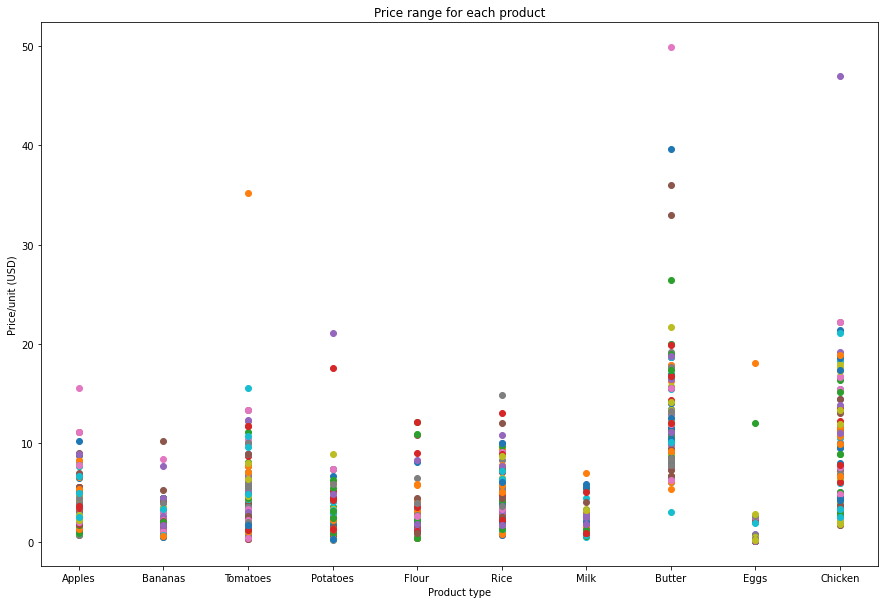

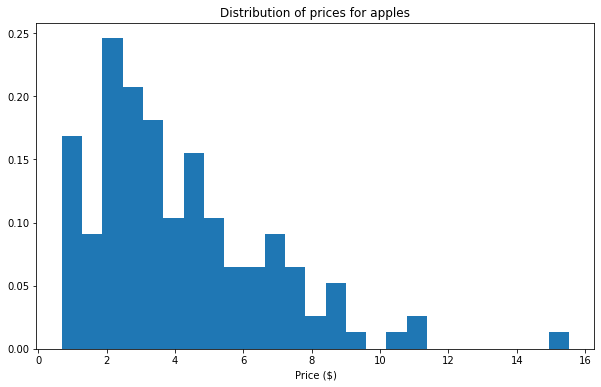

In [12]:
#1. Product price for each product and for Apples

#Create figure
plt.figure(figsize = (15,10)) 

#Go through each product category
for key in product_data_cate.keys():

  #For each entry
  for entry in product_data_cate[key]:

    #Plot the category integer and the price
    plt.scatter(product_cate[key], entry[0])

plt.xticks(np.arange(1, 11), products)
plt.title("Price range for each product")
plt.xlabel("Product type")
plt.ylabel("Price/unit (USD)")
plt.show()

plt.figure(figsize = (10, 6))
plt.hist([entry[0] for entry in product_data_cate["Apples"]], bins = 25, density = True)
plt.title("Distribution of prices for apples")
plt.xlabel("Price ($)")
plt.show()

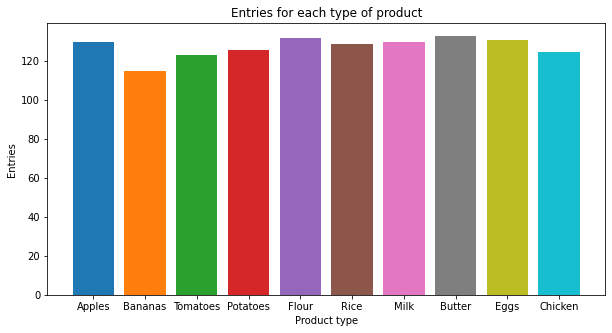

In [13]:
#2. Entries for each product

#Create figure
plt.figure(figsize = (10,5)) 

#Go through each product category
for key in product_data_cate.keys():

  plt.bar(product_cate[key], len(product_data_cate[key]))

plt.xticks(np.arange(1, 11), products)
plt.title("Entries for each type of product")
plt.xlabel("Product type")
plt.ylabel("Entries")
plt.show()

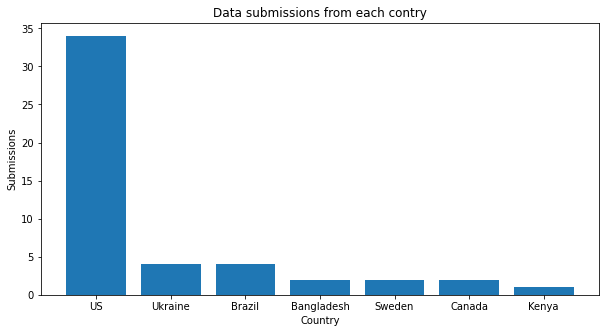

In [14]:
#3. Country submissions

#Create figure
plt.figure(figsize = (10,5)) 

#Counts for each country
counts = clear_data["Country"].value_counts()

#Create bar chart
plt.bar(np.arange(0, len(counts)), counts)

plt.xticks(np.arange(0, len(counts)), counts.index)
plt.title("Data submissions from each contry")
plt.xlabel("Country")
plt.ylabel("Submissions")
plt.show()

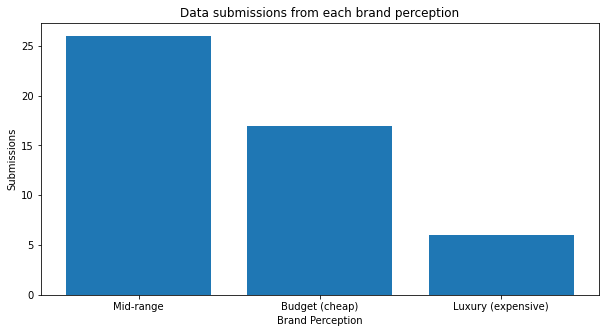

In [15]:
#4. Brand_perceotion submissions

#Create figure
plt.figure(figsize = (10,5)) 

#Counts for each brand_view
counts = clear_data["Brand_view"].value_counts()

#Create bar chart
plt.bar(np.arange(0, len(counts)), counts)

plt.xticks(np.arange(0, len(counts)), counts.index)
plt.title("Data submissions from each brand perception")
plt.xlabel("Brand Perception")
plt.ylabel("Submissions")
plt.show()

# Section 2 - Stan model and inference

In the below section, the stan model will be implementedd and will be used to draw inference about product price.

As per the assignment description, we will build a model where the product price is the dependent variable, and the product type, country, and brand perception is the independent variables. 

We will treat each brand perception, each country, and each product type as categorical values and we want to find a factor multiplicate for each category that lets us estimate the product price in a store of certain perception in a specific country.

We here assume that each categorical value is independent from each other and that the categories are not ordered. 

This means that knowing the factor multiplicate for US will not inform the factor multiplicate for Sweden. 

Similarly, knowing the factor multiplicate for a budget store doesn't inform about the factor multiplicate for a luxury store. This assumption is a simplification since we do know that the price is very likely to be higher in the luxury store. This could be implemented in an extended version of the model.


## Data preperation

In our model, we don't want to compute any of the independent variables conditioned on a variable. I.e. we don't want to build a model where the base price is computed given the country or where the factor multiplication is computed given a certain product. This is because we want a general factor multiplicate for each country, not for each country given each product.

We thus combine all our data into a large dataset.

This was also the reason why we coded the brand_view, country, and product into integers. This will make the processes of referencing to country factors etc in our stan model east

In [16]:
#list for all the data
product_stan_data = []

#Loop through each product
for key in product_data_cate.keys():

  #Add/exted the entries to the list
  product_stan_data.extend(product_data_cate[key])

#Save it as a numpy file for each access column data
product_stan_data = np.array(product_stan_data)
print(f"An example of how an entry in the data set looks: \n{product_stan_data[0]}")

An example of how an entry in the data set looks: 
[2.75919118e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.14550000e+03]


## The model and stan code

In the model, we want to compute posterior values for the independent variable, or parameters. 

The parameters are: 

*   Country multiplier
*   Store perception multiplier
*   Base price

The posterior is p(parameters | Data).

The likelihood function is p(price | parameters). In this case, the likelihood function would be 
p(base_price[product] * store_per_muli[store] * country_multi[country])

From the data vizualisations for each product, we see that they are positive real numbers and it's somewhat right skewed. The likelihood function will thus be modeled as a lognormal distribution with mu = base_price[product] * store_per_muli[store] * country_multi[country] and with a variance sigma specific for each product. 

Likelihood: lognormal(mu = base_price[product] * store_per_muli[store] * country_multi[country], sd = sigma)

Prior of each parameter

*   Base price: The prior base price for each product will be the same and will be uninformative. The base price should be a positive real and give fairly equal probability to a large range of values. The prior will thus be a truncated cauchys distribution. base_price ~ cauchys(0,5) [0,]
*   Store perception multiplier: I believe that an expensive store should not be more than thrice as expensive as the base price. I also believe that the the multiplier should be fairly uniformly distributed around a mean of 1. The prior will thus be a truncated normal distribution. store_per_muli ~ normal(1,0.5) [0,3]
*   Country multiplier: Same as for the store perception. I dont belive that the the most expensive country will be more than thrice as expensive as the base price, and that the multipliers should be uniformly distributed around 1. It will thus be a trucated normal distribution. country_multi ~ normal(1,0.5) [0,3]
*   Sigma: Sigma will be sampled from an gamma disribution with sigma~gamma(2, 10). This will be right skewed distribution with positive real values and a mean of 0.2. I've decided to use a different sigma for each product, since I believe some product will vary less than others.


In [17]:
stan_code = """

data {
    int<lower=1> n; // The number of data point
    real<lower=0> price_data[n];  // The data point prices

    int<lower=1> c; // The number of unique countries
    int<lower=1> countries_data[n]; // The number of country data points

    int<lower=1> b; // The number of unique brand perception
    int<lower=1> perception_data[n]; // The number of perception data points

    int<lower=1> p; // The number of product categories picked
    int<lower=1> product_data[n]; // The number of product data points

    real base_prior_x; // Prior x for cauchys distribution for base price
    real base_prior_y; // Prior y for cauchys distribution for base price

    real multi_mu; // Prior mu for factor multiplier 
    real multi_sigma; // Prior sigma for factor multiplier 

    real sigma_alpha; // Prior x for gamma distribution for sigma
    real sigma_beta; // Prior y for gamma distribution for sigma
}

parameters {
    real<lower=0> base_price[p]; // Base price for each product
    real<lower=0> country[c]; // Country multiplier
    real<lower=0> perception[b]; // Brand perception multiplier
    real<lower=0> price_sigma[p]; // Variance for produce price for each product
}

model {

    base_price ~ cauchy(base_prior_x, base_prior_y); // Prior for base price

    country ~ normal(multi_mu, multi_sigma); // Prior for country

    perception ~ normal(multi_mu, multi_sigma); // Prior for perception

    price_sigma ~ gamma(sigma_alpha, sigma_beta); // Prior for sigma

    for (i in 1:n) {
      real mu;
      mu = base_price[product_data[i]] * country[countries_data[i]] * perception[perception_data[i]];
      price_data[i] ~ normal(mu, price_sigma[product_data[i]]); // [product_data[i]]Likelihood function;
    }
}

"""

In [18]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_574f5c5f1c6ae8e3517f68e125216c41 NOW.


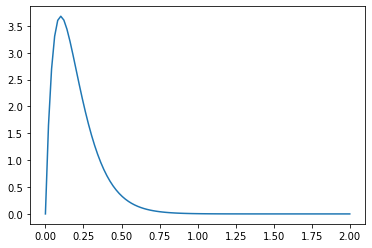

In [19]:
#Plot for the prior sigma
plt.plot(np.linspace(0,2,100), sts.gamma(a = 2, scale = 1/10).pdf(np.linspace(0,2,100)))

## Stan data and posterior samples


In this section, the model will be run for the data collected from grocery stores.

The data is prepared by first transposing the data where each row is a entry. Makes extracting the data vectors easy. The first row will correspond to the prices, the second row the product category, third row the country category, and forth row the brand category.

In [20]:
#Transpose to make columns into rows
product_stan_data_transpose = np.array(product_stan_data).transpose()

stan_data = {
    "n": product_stan_data_transpose.shape[1],
    "price_data": product_stan_data_transpose[0],

    "p": len(product_cate),
    "product_data": product_stan_data_transpose[1].astype(int),

    "c": len(country_cate), 
    "countries_data": product_stan_data_transpose[2].astype(int),

    "b": len(brand_cate), 
    "perception_data": product_stan_data_transpose[3].astype(int),

    "base_prior_x": 0,
    "base_prior_y": 5,

    "multi_mu": 1, 
    "multi_sigma": 0.5,

    "sigma_alpha": 2,
    "sigma_beta": 10
}

In [21]:
#Sample posterior variance and mean using the normal data
posterior = stan_model.sampling(data=stan_data)

#print the posterior statistics
print(posterior)

Inference for Stan model: anon_model_574f5c5f1c6ae8e3517f68e125216c41.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]     4.46    0.06   1.24   2.67    3.6   4.26   5.09   7.57    459   1.01
base_price[2]     2.26    0.03   0.63   1.34   1.82   2.15   2.57    3.8    468   1.01
base_price[3]     5.64    0.07   1.58   3.38   4.55   5.38   6.42   9.55    457   1.01
base_price[4]     2.95    0.04   0.82   1.76   2.37   2.81   3.35   5.01    472   1.01
base_price[5]     2.53    0.03   0.72    1.5   2.03   2.42   2.89    4.3    482   1.01
base_price[6]     4.73    0.06   1.32   2.85   3.82   4.51   5.37   8.01    459   1.01
base_price[7]     1.84    0.02   0.51    1.1   1.48   1.76   2.08   3.09    448   1.01
base_price[8]    12.44    0.16   3.44   7.48  10.05  11.87  14.15  20.96    451   1.01
base_price[9]     0.63  8.6e

In [22]:
#Extract the samples for plotting
posterior_sample = posterior.extract()

## Posterior plots and inference

Here, I will plot posterior samples for each parameter.

### Posterior plot for base price

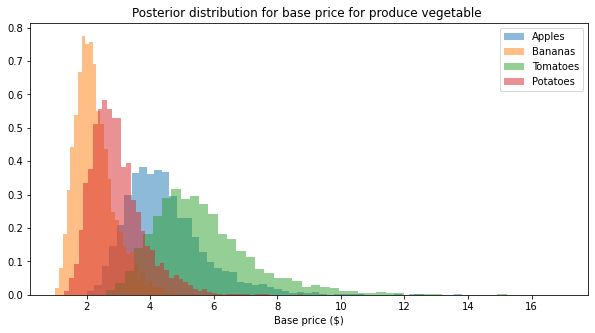

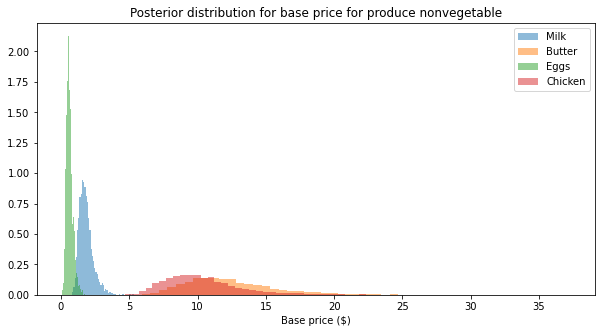

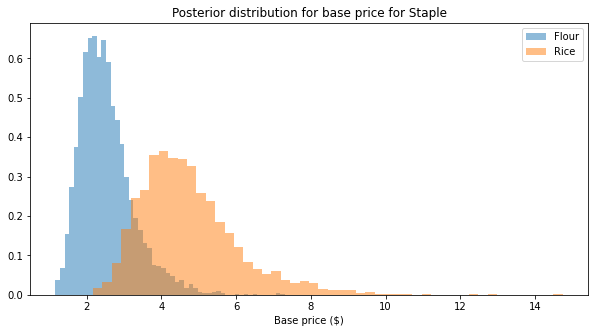

{'Apples': [[4.463253825934495, array([2.67455019, 7.56402829])]],
 'Bananas': [[2.2589988963430434, array([1.34087219, 3.79276594])]],
 'Butter': [[12.437189781493588, array([ 7.48952483, 20.95670495])]],
 'Chicken': [[10.382324032256362, array([ 6.27780934, 17.3740287 ])]],
 'Eggs': [[0.6300447279537905, array([0.26584315, 1.2091936 ])]],
 'Flour': [[2.5305789594280097, array([1.50532709, 4.29666214])]],
 'Milk': [[1.836662487151413, array([1.10376284, 3.09214143])]],
 'Potatoes': [[2.949622274883072, array([1.75909075, 5.00331091])]],
 'Rice': [[4.728603283188853, array([2.84832474, 8.00710327])]],
 'Tomatoes': [[5.63798106658199, array([3.37894864, 9.54886235])]]}

In [23]:
#lists of the product categories
main_cate_prod = {
    "produce vegetable ": ["Apples", "Bananas", "Tomatoes", "Potatoes"],
    "produce nonvegetable": ["Milk", "Butter", "Eggs", "Chicken"],
    "Staple": ["Flour", "Rice"],
}

#dictionary for product stats
posterior_prod_stats = {"Apples": [], "Bananas": [], "Tomatoes": [], "Potatoes": [], 
                 "Flour": [], "Rice": [], "Milk": [], "Butter": [], 
                 "Eggs": [], "Chicken": []}  

#Loop through each product category
for prod_cate in main_cate_prod.keys():

  #Create a figure
  plt.figure(figsize = (10,5))

  #Set the title
  plt.title(f"Posterior distribution for base price for {prod_cate}")

  #Loop through each product
  for product in main_cate_prod[prod_cate]:
    posterior_values = posterior_sample["base_price"][:, product_cate[product]-1]
    #Plot the samples
    plt.hist(posterior_values, density = True, 
             label = product, alpha = 0.5, bins = 50)
    
    #Add the mean and percentiles
    posterior_prod_stats[product].append(
        [np.mean(posterior_values),np.percentile(posterior_values, (2.5, 97.5))])
  plt.xlabel("Base price ($)")   
  plt.legend()
  plt.show()

posterior_prod_stats

### Posterior plot for country multiplier

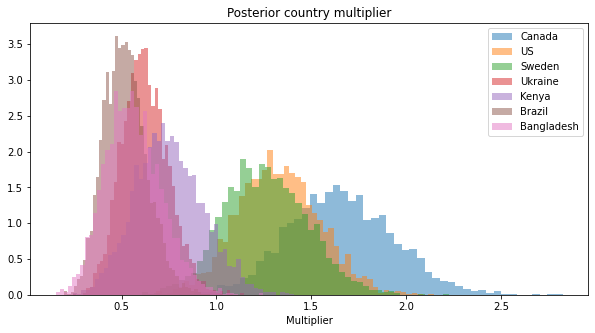

{'Bangladesh': [[0.5605704568871356, array([0.30191619, 0.87273634])]],
 'Brazil': [[0.5196702701431423, array([0.32186944, 0.7556265 ])]],
 'Canada': [[1.6552107059231758, array([1.14012907, 2.21740992])]],
 'Kenya': [[0.7514078261065322, array([0.42476883, 1.12104353])]],
 'Sweden': [[1.2597895984859875, array([0.8447858 , 1.70736341])]],
 'US': [[1.326776032785873, array([0.91225993, 1.76547713])]],
 'Ukraine': [[0.6246520273482511, array([0.40119381, 0.87683944])]]}

In [24]:
#Creat figure
plt.figure(figsize = (10,5))

posterior_country_stats = {'Bangladesh': [],
 'Brazil': [],
 'Canada': [],
 'Kenya': [],
 'Sweden': [],
 'US': [],
 'Ukraine': []}

#Loop though each country
for country in country_cate.keys():

  #title
  plt.title(f"Posterior country multiplier")

  #Plot the samples
  posterior_values = posterior_sample["country"][:, country_cate[country]-1]
  plt.hist(posterior_values,
           density = True, bins = 50, alpha = 0.5, label = country)
  
  #Add mean and confidence intervalls
  posterior_country_stats[country].append(
      [np.mean(posterior_values),np.percentile(posterior_values, (2.5, 97.5))])


plt.xlabel("Multiplier")
plt.legend()
plt.show()

posterior_country_stats

### Posterior for brand perception

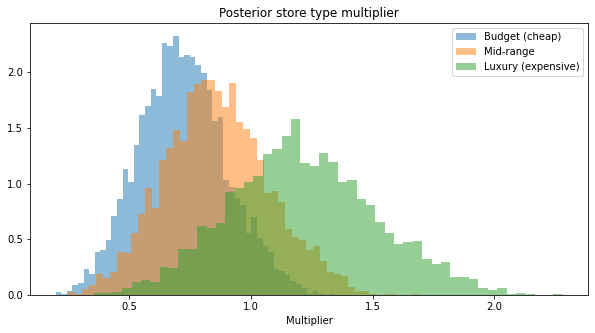

{'Budget (cheap)': [[0.7183409236007054, array([0.38288193, 1.0833409 ])]],
 'Luxury (expensive)': [[1.2138469051760308, array([0.65191322, 1.82467628])]],
 'Mid-range': [[0.858746926501581, array([0.46381214, 1.29873765])]]}

In [29]:
#Creat figure
plt.figure(figsize = (10,5))

posterior_brand_stats = {'Budget (cheap)': [], 'Luxury (expensive)': [], 'Mid-range': []}

#Loop though each brand
for brand in brand_cate.keys():

  #title
  plt.title(f"Posterior store type multiplier")

  #Plot the samples
  posterior_values = posterior_sample["perception"][:, brand_cate[brand]-1]
  plt.hist(posterior_values,
           density = True, bins = 50, alpha = 0.5, label = brand)
  
  #Add mean and confidence intervals
  posterior_brand_stats[brand].append(
      [np.mean(posterior_values),np.percentile(posterior_values, (2.5, 97.5))])


plt.xlabel("Multiplier")
plt.legend()
plt.show()

posterior_brand_stats

# Rental price and location

To investigate whether there is a correlation between the product price in a country and the rent in the country, I will build a model for the average rent in a country dependent on the country multiplier.

The average rents will be derived from the raw data while the country multiplier will be the average posterior multiplier from above.

If there is a correlation between the product price per location and rent, we should be able to fit a linear regression line to the data.

In [26]:
#Country rents
country_rent = {'Bangladesh': [],
 'Brazil': [],
 'Canada': [],
 'Kenya': [],
 'Sweden': [],
 'US': [],
 'Ukraine': []}

#Go through each row in the raw data set and append the rent to the correct country
for row in range(clear_data.shape[0]):

   country_rent[clear_data['Country'][row]].append(clear_data["Rent"][row])

#take the mean for each country
for country in country_rent.keys():

  country_rent[country] = np.mean(country_rent[country])

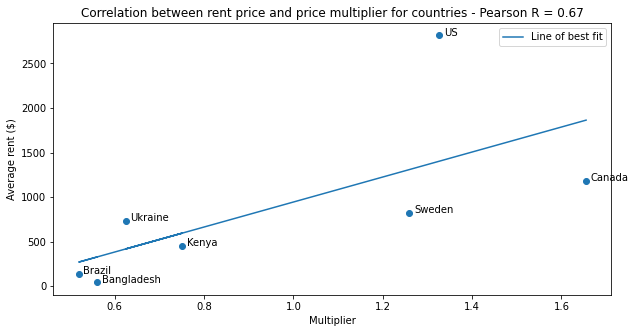

In [27]:
#lists for the data
x_val = []
y_val = []

#Append the data for each country
for country in country_cate.keys():

  y_val.append(country_rent[country])

  x_val.append(posterior_country_stats[country][0][0])

#Numpy data
x_val = np.array(x_val).reshape(-1,1)
y_val = np.array(y_val)

#linear model
l_model = LinearRegression().fit(x_val, y_val)

#predicted rents
y_predict = l_model.predict(x_val)

plt.figure(figsize = (10,5))
plt.scatter(x_val, y_val)
plt.plot(x_val, y_predict, 
         label = f"Line of best fit")
for i, txt in enumerate(country_cate.keys()):
    plt.annotate(txt, (x_val[i]+0.01, y_val[i]+0.01))
  
plt.title(f"Correlation between rent price and price multiplier for countries - Pearson R = {sts.pearsonr([x[0] for x in x_val], [y for y in y_val])[0]:.2f}")
plt.xlabel("Multiplier")
plt.ylabel("Average rent ($)")
plt.legend()
plt.show()
